# **딥러닝 모델 훈련 및 추론**

## **1. 드라이브 연결**

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


## **2. 파라미터 설정, 데이터 로드, 데이터셋 분리**

- 데이터 전처리: MinMax Scaler
- 데이터 증강: Sliding Window

In [2]:
# ==========================================
# 1. 라이브러리 및 환경 설정
# ==========================================
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# 2. 전처리 코어 함수 (Preprocessing Core)
# ==========================================
def load_raw_data(file_path):
    """엑셀 또는 CSV 파일을 로드합니다."""
    if not os.path.exists(file_path):
        print(f"❌ Error: File not found at {file_path}")
        return pd.DataFrame()

    print(f"📂 Loading data from: {file_path}")
    if file_path.endswith('.xlsx'):
        return pd.read_excel(file_path)
    else:
        return pd.read_csv(file_path)

def create_sequences_with_ids(df_target, wafer_col, sensor_cols, seq_len, scaler=None, is_train=True):
    """
    데이터를 윈도우 단위로 자르고, 각 윈도우의 소스 Wafer ID를 추적합니다.
    - is_train=True: Scaler를 학습(fit)하고 변환합니다.
    - is_train=False: 기존 Scaler로 변환(transform)만 수행합니다 (Leakage 방지).
    """
    data_values = df_target[sensor_cols].values

    # 스케일링
    if is_train:
        if scaler is None: scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data_values)
    else:
        if scaler is None: raise ValueError("Test mode requires a fitted scaler.")
        data_scaled = scaler.transform(data_values)

    # 스케일링된 데이터를 DataFrame으로 매핑 (ID 추적용)
    df_scaled = pd.DataFrame(data_scaled, columns=sensor_cols, index=df_target.index)
    df_scaled[wafer_col] = df_target[wafer_col].values

    all_sequences = []        # 시퀀스 저장
    all_wafer_ids = []        # 시퀀스 별 해당하는 Wafer_ID 저장

    # 웨이퍼별로 그룹화하여 슬라이딩 윈도우 적용
    for wafer in df_scaled[wafer_col].unique():
        wafer_data = df_scaled[df_scaled[wafer_col] == wafer][sensor_cols].values

        if len(wafer_data) < seq_len:
            continue

        for i in range(len(wafer_data) - seq_len + 1):
            all_sequences.append(wafer_data[i : i + seq_len])
            all_wafer_ids.append(wafer)

    if len(all_sequences) == 0:
        return np.array([]), np.array([]), scaler

    return np.array(all_sequences), np.array(all_wafer_ids), scaler

def prepare_experiments_dataset(df, experiments_list, sensor_cols, seq_len=32, train_ratio=0.7):
    """
    각 실험(l29, l31 등)별로 독립된 데이터셋을 생성하여 딕셔너리에 저장합니다.
    """
    datasets = {}

    print(f"\n🚀 Preparing Datasets for Separate Experiments: {experiments_list}")
    print(f"   Train Ratio: {train_ratio*100}% | Sequence Length: {seq_len}")

    for exp_id in experiments_list:
        print(f"\n🔹 Processing: {exp_id}")

        # 1. 해당 실험 데이터 필터링
        exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]
        if exp_df.empty:
            print(f"   ⚠️ Skipping {exp_id}: No data found.")
            continue

        # 2. Wafer ID 추출 및 분할 (정상/불량)
        normal_wafer_ids = exp_df[exp_df['Label'] == 'Normal']['Wafer_ID'].unique()
        fault_wafer_ids = exp_df[exp_df['Label'] == 'Fault']['Wafer_ID'].unique()

        # 정상 데이터 분할 (Train / Test Normal)
        n_train = int(len(normal_wafer_ids) * train_ratio)
        train_ids = normal_wafer_ids[:n_train]
        test_norm_ids = normal_wafer_ids[n_train:]

        # 데이터프레임 분할
        df_train = exp_df[exp_df['Wafer_ID'].isin(train_ids)]
        df_test_norm = exp_df[exp_df['Wafer_ID'].isin(test_norm_ids)]
        df_test_fault = exp_df[exp_df['Wafer_ID'].isin(fault_wafer_ids)]

        print(f"   - Train Normal: {len(train_ids)} wafers")
        print(f"   - Test Normal : {len(test_norm_ids)} wafers")
        print(f"   - Test Fault  : {len(fault_wafer_ids)} wafers")

        # 3. 시퀀스 생성 & 스케일링
        # Train (Fit & Transform)
        X_train, ids_train, scaler = create_sequences_with_ids(
            df_train, 'Wafer_ID', sensor_cols, seq_len, scaler=None, is_train=True
        )

        # Test (Transform Only)
        X_test_norm, ids_test_norm, _ = create_sequences_with_ids(
            df_test_norm, 'Wafer_ID', sensor_cols, seq_len, scaler=scaler, is_train=False
        )

        X_test_fault, ids_test_fault, _ = create_sequences_with_ids(
            df_test_fault, 'Wafer_ID', sensor_cols, seq_len, scaler=scaler, is_train=False
        )

        # 4. 결과 저장
        datasets[exp_id] = {
            'X_train': X_train,
            'X_test_norm': X_test_norm,
            'ids_test_norm': ids_test_norm,
            'X_test_fault': X_test_fault,
            'ids_test_fault': ids_test_fault,
            'scaler': scaler,
            'seq_len': seq_len,
            'n_features': len(sensor_cols)
        }

    print(f"\n✅ All datasets prepared successfully.")
    return datasets


# ==========================================
# 4. 실행 및 데이터셋 생성 (여기서 실행)
# ==========================================
FILE_PATH = "/content/drive/MyDrive/ASK_2026_FDC/Dataset/MACHINE_Data.xlsx"
SENSOR_COLS = [
    'BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A',
    'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err',
    'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err',
    'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve'
]
TARGET_EXPERIMENTS = ['l29', 'l31', 'l33']

# 1. 데이터 로드
raw_df = load_raw_data(FILE_PATH)

# 2. 실험별 독립 데이터셋 생성
if not raw_df.empty:
    datasets = prepare_experiments_dataset(
        raw_df,
        TARGET_EXPERIMENTS,
        SENSOR_COLS,
        seq_len=32,
        train_ratio=0.7  # 7:3 분할
    )
else:
    print("Dataset generation failed.")

Using device: cuda
📂 Loading data from: /content/drive/MyDrive/ASK_2026_FDC/Dataset/MACHINE_Data.xlsx

🚀 Preparing Datasets for Separate Experiments: ['l29', 'l31', 'l33']
   Train Ratio: 70.0% | Sequence Length: 32

🔹 Processing: l29
   - Train Normal: 23 wafers
   - Test Normal : 11 wafers
   - Test Fault  : 9 wafers

🔹 Processing: l31
   - Train Normal: 25 wafers
   - Test Normal : 12 wafers
   - Test Fault  : 6 wafers

🔹 Processing: l33
   - Train Normal: 25 wafers
   - Test Normal : 12 wafers
   - Test Fault  : 6 wafers

✅ All datasets prepared successfully.


## **3. 함수 설정**

In [3]:
# ==========================================
# 3. 표준 유틸리티 함수 (Standard Utilities)
# ==========================================
def get_data_loaders(exp_id, datasets_dict, batch_size=32):
    """
    특정 실험(exp_id)의 데이터를 가져와 DataLoader와 Tensor로 반환합니다.
    """
    if exp_id not in datasets_dict:
        raise ValueError(f"Experiment ID {exp_id} not found in datasets.")

    data = datasets_dict[exp_id]

    X_train = data['X_train']
    X_test_norm = data['X_test_norm']
    ids_test_norm = data['ids_test_norm']
    X_test_fault = data['X_test_fault']
    ids_test_fault = data['ids_test_fault']

    # Tensor 변환
    train_tensor = torch.FloatTensor(X_train).to(device)
    test_norm_tensor = torch.FloatTensor(X_test_norm).to(device)

    if len(X_test_fault) > 0:
        test_fault_tensor = torch.FloatTensor(X_test_fault).to(device)
    else:
        test_fault_tensor = torch.FloatTensor([]).to(device)

    # Train Loader (Shuffle=True)
    train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)

    # Test Data는 Tensor와 ID 그대로 반환
    return train_loader, (test_norm_tensor, ids_test_norm), (test_fault_tensor, ids_test_fault)

def aggregate_wafer_scores(window_scores, wafer_ids, method='max'):
    """윈도우 점수를 웨이퍼 단위로 집계"""
    df_temp = pd.DataFrame({'Wafer_ID': wafer_ids, 'Score': window_scores})

    if method == 'max':
        grouped = df_temp.groupby('Wafer_ID')['Score'].max()
    else:
        grouped = df_temp.groupby('Wafer_ID')['Score'].mean()

    return grouped.index.values, grouped.values

def visualize_results(model_name, exp_id, scores, labels, threshold):
    """평가 결과 시각화 (Confusion Matrix, Scatter Plot, ROC Curve)"""
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"[{exp_id}] {model_name} Performance (Wafer-Level)", fontsize=16, fontweight='bold')

    # 1. Confusion Matrix
    preds = (scores > threshold).astype(int)
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
                xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'])
    axes[0].set_title("Confusion Matrix")
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. Scatter Plot
    normal_idx = np.where(labels == 0)[0]
    fault_idx = np.where(labels == 1)[0]

    axes[1].scatter(normal_idx, scores[normal_idx], color='blue', label='Normal', alpha=0.6, s=30)
    axes[1].scatter(fault_idx, scores[fault_idx], color='red', label='Fault', alpha=0.6, s=30)
    axes[1].axhline(y=threshold, color='green', linestyle='--', linewidth=2, label='Threshold')
    axes[1].set_title("Wafer Anomaly Scores")
    axes[1].set_xlabel("Wafer Index")
    axes[1].legend()

    # 3. ROC Curve
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    axes[2].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[2].set_title("ROC Curve")
    axes[2].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def evaluate_performance(model_name, exp_id, scores, labels):
    """최종 성능 평가 및 출력"""
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * recall * precision / (recall + precision)
    f1_scores = np.nan_to_num(f1_scores)

    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    best_thresh = thresholds[best_idx]

    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    print(f"\n📌 [{model_name} - {exp_id}] Evaluation Result")
    print(f"   - AUROC         : {roc_auc:.4f}")
    print(f"   - Best F1-Score : {best_f1:.4f}")
    print(f"   - Best Threshold: {best_thresh:.6f}")

    visualize_results(model_name, exp_id, scores, labels, best_thresh)
    return roc_auc, best_f1


# **모델 구현 및 추론**

## **TRACE-GPT**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# ==========================================
# 1. TRACE-GPT 모델 정의 (Fixed Architecture)
# ==========================================
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=self.padding, dilation=dilation)

    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.padding]

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [
                CausalConv1d(in_channels, out_channels, kernel_size, dilation=dilation_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TRACE_GPT(nn.Module):
    def __init__(self, num_sensors, seq_len, d_model=64, n_head=8, num_layers=6, resolution=100, dropout=0.1):
        super(TRACE_GPT, self).__init__()
        self.num_sensors = num_sensors
        self.seq_len = seq_len
        self.resolution = resolution
        self.d_model = d_model

        # TCN 4층 (Receptive Field 확보)
        tcn_channels = [d_model] * 4

        # 1. Embedding Layer
        self.tcn = TemporalConvNet(
            num_inputs=num_sensors + 1, # +1 for Time Index
            num_channels=tcn_channels,
            kernel_size=3,
            dropout=dropout
        )

        # 2. Transformer Decoder
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=d_model, nhead=n_head, batch_first=True, dropout=dropout),
            num_layers=num_layers
        )

        # 3. Output Head
        self.output_head = nn.Linear(d_model, num_sensors * resolution)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        batch_size, curr_seq_len, _ = x.size()

        # Absolute Positional Embedding
        steps = torch.arange(curr_seq_len, device=x.device, dtype=torch.float32)
        time_idx = (steps / self.seq_len).unsqueeze(0).unsqueeze(2)
        time_idx = time_idx.expand(batch_size, -1, -1)

        x_emb = torch.cat([x, time_idx], dim=2)

        # TCN Forward
        x_tcn = x_emb.permute(0, 2, 1)
        x_tcn = self.tcn(x_tcn)
        x_tcn = x_tcn.permute(0, 2, 1)

        # Transformer Forward
        tgt_mask = self._generate_square_subsequent_mask(curr_seq_len).to(x.device)
        output = self.transformer_decoder(x_tcn, x_tcn, tgt_mask=tgt_mask)

        # Output Head
        logits = self.output_head(output)
        logits = logits.view(batch_size, curr_seq_len, self.num_sensors, self.resolution)

        return logits


# ==========================================
# 2. 학습 및 추론 핵심 함수
# ==========================================
def quantize_data(x, resolution=100):
    """실수 데이터를 정수 인덱스로 양자화"""
    x_idx = (x * (resolution - 1)).long()
    x_idx = torch.clamp(x_idx, 0, resolution - 1)
    return x_idx

def train_epoch(model, train_loader, optimizer, device, resolution=100):
    model.train()
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    for (data,) in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Next Token Prediction: t 시점으로 t+1 예측
        input_seq = data[:, :-1, :]   # 0 ~ T-1
        target_seq = data[:, 1:, :]   # 1 ~ T
        target_idx = quantize_data(target_seq, resolution)

        output_logits = model(input_seq)

        loss = criterion(
            output_logits.reshape(-1, resolution),
            target_idx.reshape(-1)
        )

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)

def calculate_window_scores(model, data_tensor, device, batch_size=32, resolution=100):
    """윈도우 단위 이상 점수 계산 (Reconstruction Error)"""
    model.eval()
    all_scores = []
    criterion = nn.CrossEntropyLoss(reduction='none')

    dataset = TensorDataset(data_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for (data,) in loader:
            data = data.to(device)

            input_seq = data[:, :-1, :]
            target_seq = data[:, 1:, :]
            target_idx = quantize_data(target_seq, resolution)

            output_logits = model(input_seq)

            # Element-wise Loss
            loss_element = criterion(
                output_logits.reshape(-1, resolution),
                target_idx.reshape(-1)
            )
            loss_element = loss_element.view(input_seq.shape[0], input_seq.shape[1], input_seq.shape[2])

            # Mean over (Time, Sensors)
            score_window = loss_element.mean(dim=[1, 2])
            all_scores.extend(score_window.cpu().numpy())

    return np.array(all_scores)


🚀 Starting TRACE-GPT Experiments...

>>> Running Experiment: l29
   Training...
     Epoch 5: Loss 2.2615
     Epoch 10: Loss 2.1456
   Inference...

📌 [TRACE-GPT - l29] Evaluation Result
   - AUROC         : 1.0000
   - Best F1-Score : 1.0000
   - Best Threshold: 2.907202


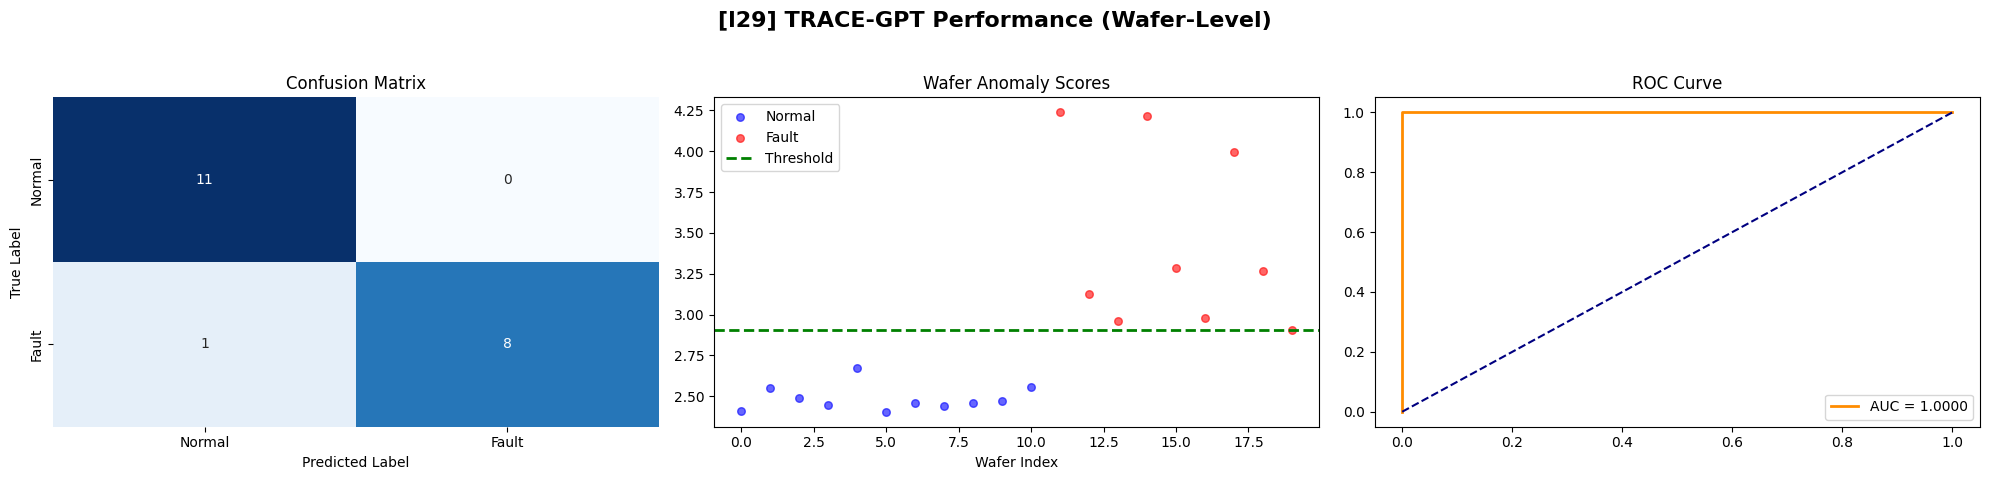


>>> Running Experiment: l31
   Training...
     Epoch 5: Loss 2.2772
     Epoch 10: Loss 2.1504
   Inference...

📌 [TRACE-GPT - l31] Evaluation Result
   - AUROC         : 1.0000
   - Best F1-Score : 1.0000
   - Best Threshold: 2.903994


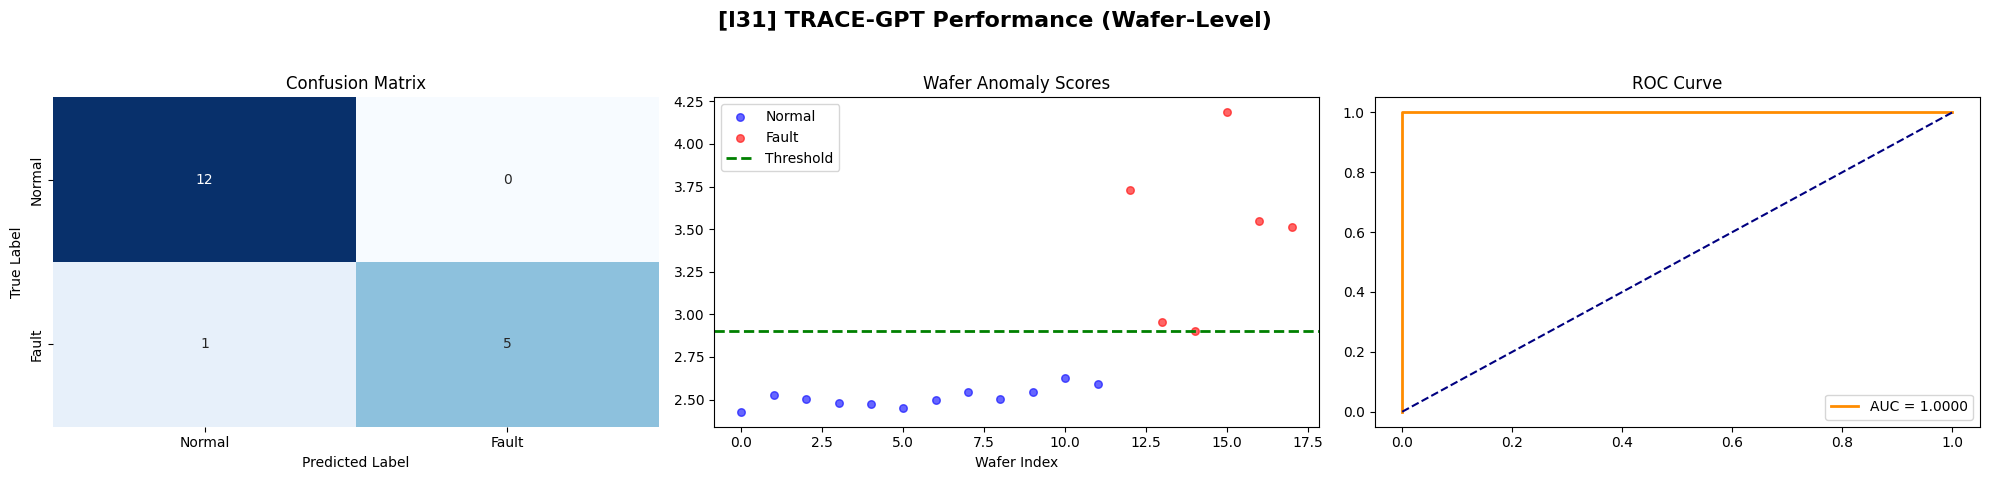


>>> Running Experiment: l33
   Training...
     Epoch 5: Loss 2.2992
     Epoch 10: Loss 2.1574
   Inference...

📌 [TRACE-GPT - l33] Evaluation Result
   - AUROC         : 1.0000
   - Best F1-Score : 1.0000
   - Best Threshold: 2.719780


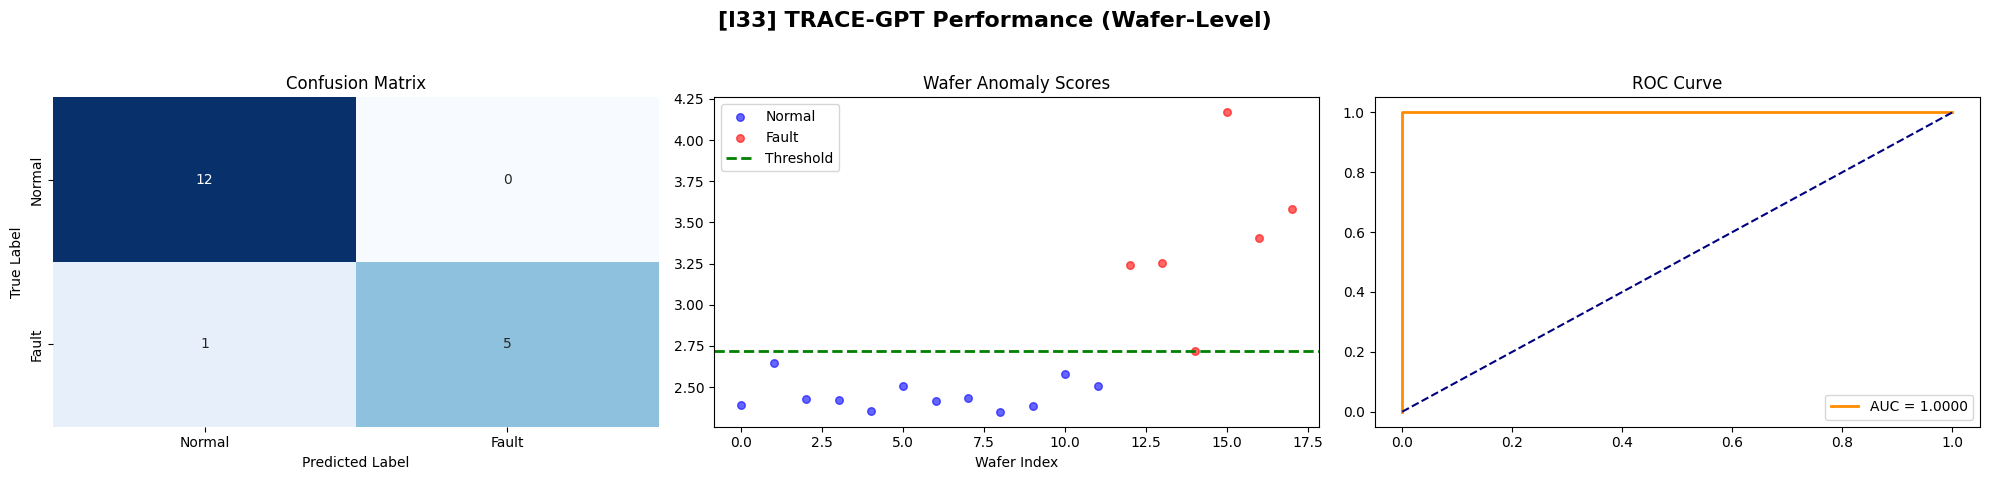


✅ All experiments finished.
{'l29': {'AUC': np.float64(1.0), 'F1': np.float64(1.0)}, 'l31': {'AUC': np.float64(1.0), 'F1': np.float64(1.0)}, 'l33': {'AUC': np.float64(1.0), 'F1': np.float64(1.0)}}


In [5]:
# ==========================================
# 3. 메인 실행 루프 (실험별 독립 수행)
# ==========================================
# 하이퍼파라미터
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
D_MODEL = 64
RESOLUTION = 100

results = {}
target_experiments = ['l29', 'l31', 'l33']

print(f"\n🚀 Starting TRACE-GPT Experiments...")

for exp_id in target_experiments:
    # 데이터셋 확인
    if exp_id not in datasets:
        print(f"Skipping {exp_id}: Dataset not found.")
        continue

    print(f"\n>>> Running Experiment: {exp_id}")

    # 1. 데이터 로드 (표준 함수 사용)
    # get_data_loaders 함수는 이전 셀(유틸리티)에서 정의되었습니다.
    train_loader, (test_norm, ids_norm), (test_fault, ids_fault) = get_data_loaders(exp_id, datasets, BATCH_SIZE)

    # 2. 모델 초기화 (실험마다 새로 생성)
    num_sensors = datasets[exp_id]['n_features']
    seq_len_input = datasets[exp_id]['seq_len'] - 1 # Next token prediction용 길이

    model = TRACE_GPT(
        num_sensors=num_sensors,
        seq_len=seq_len_input,
        d_model=D_MODEL,
        resolution=RESOLUTION
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 3. 학습
    print("   Training...")
    for epoch in range(NUM_EPOCHS):
        loss = train_epoch(model, train_loader, optimizer, device, RESOLUTION)
        if (epoch+1) % 5 == 0:
            print(f"     Epoch {epoch+1}: Loss {loss:.4f}")

    # 4. 추론 (Window Scores)
    print("   Inference...")
    norm_w_scores = calculate_window_scores(model, test_norm, device, BATCH_SIZE, RESOLUTION)

    if len(test_fault) > 0:
        fault_w_scores = calculate_window_scores(model, test_fault, device, BATCH_SIZE, RESOLUTION)
    else:
        fault_w_scores = np.array([])

    # 5. 집계 (Wafer Aggregation)
    # aggregate_wafer_scores 함수는 이전 셀(유틸리티)에서 정의되었습니다.
    _, norm_wafer_scores = aggregate_wafer_scores(norm_w_scores, ids_norm, method='max')
    norm_labels = np.zeros(len(norm_wafer_scores))

    if len(fault_w_scores) > 0:
        _, fault_wafer_scores = aggregate_wafer_scores(fault_w_scores, ids_fault, method='max')
        fault_labels = np.ones(len(fault_wafer_scores))
    else:
        fault_wafer_scores = np.array([])
        fault_labels = np.array([])

    # 병합
    final_scores = np.concatenate([norm_wafer_scores, fault_wafer_scores])
    final_labels = np.concatenate([norm_labels, fault_labels])

    # 6. 평가 (Standard Evaluation)
    # evaluate_performance 함수는 이전 셀(유틸리티)에서 정의되었습니다.
    auc_score, f1 = evaluate_performance("TRACE-GPT", exp_id, final_scores, final_labels)
    results[exp_id] = {'AUC': auc_score, 'F1': f1}

print("\n✅ All experiments finished.")
print(results)

## **VTimesNet**

In [9]:
import torch
import torch.nn as nn
import torch.fft
import torch.nn.functional as F
import numpy as np

class DilatedConvModule(nn.Module):
    """
    V-TimesNet의 특징: 확장된 수용 영역(Receptive Field)을 위한 Dilated Convolution 모듈
    """
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DilatedConvModule, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=1, dilation=1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=2, dilation=2)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=4, dilation=4)
        self.relu = nn.GELU()
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        # x: [Batch, Channels, Seq_Len]
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x1))
        x3 = self.relu(self.conv3(x2))
        out = self.bn(x3 + x1) # Residual Connection similar to ResNet
        return out

class InceptionBlockV1(nn.Module):
    """
    2D 변환된 데이터에 적용할 Vision Backbone (Inception 스타일)
    """
    def __init__(self, in_channels, out_channels, num_kernels=6):
        super(InceptionBlockV1, self).__init__()
        self.convs = nn.ModuleList()
        for i in range(num_kernels):
            self.convs.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=2 * i + 1, padding=i)
            )

    def forward(self, x):
        res_list = []
        for conv in self.convs:
            res_list.append(conv(x))
        res = torch.stack(res_list, dim=-1).mean(-1)
        return res

class TimesBlock(nn.Module):
    """
    1D 시계열을 주파수 도메인에서 분석하여 상위 k개 주기를 2D 텐서로 변환 후 학습
    """
    def __init__(self, d_model, k=3, num_kernels=6):
        super(TimesBlock, self).__init__()
        self.k = k
        self.conv = nn.Sequential(
            InceptionBlockV1(d_model, d_model, num_kernels),
            nn.GELU(),
            InceptionBlockV1(d_model, d_model, num_kernels)
        )

    def forward(self, x):
        B, C, T = x.size()

        # 1. FFT 변환
        x_fft = torch.fft.rfft(x, dim=-1)
        ampls = torch.abs(x_fft)

        # 2. 상위 k개 주파수 및 주기 추출
        avg_ampls = ampls.mean(dim=0).mean(dim=0)
        topk_ampls, topk_indices = torch.topk(avg_ampls, k=self.k)

        periods = []
        for idx in topk_indices:
            freq = idx.item()
            if freq == 0: period = 1
            else: period = T // freq
            periods.append(period)

        # 3. 1D -> 2D 변환 및 2D Conv 연산
        res = []
        for period in periods:
            # 패딩 계산 (나누어 떨어지도록)
            if T % period != 0:
                pad_len = period - (T % period)
                x_pad = F.pad(x, (0, pad_len))
            else:
                x_pad = x
                pad_len = 0

            # Reshape to 2D
            x_2d = x_pad.view(B, C, -1, period) # [Batch, Channel, Height, Width]

            # Vision Conv
            out_2d = self.conv(x_2d)

            # Reshape back to 1D
            out_1d = out_2d.view(B, C, -1)
            if pad_len > 0:
                out_1d = out_1d[..., :-pad_len]

            res.append(out_1d)

        # 4. 결과 통합 (Weighted Sum based on Amplitude)
        res = torch.stack(res, dim=-1) # [B, C, T, k]
        # Softmax weight
        weights = torch.softmax(topk_ampls, dim=-1).unsqueeze(0).unsqueeze(0).unsqueeze(0) # [1, 1, 1, k]

        out = torch.sum(res * weights.to(x.device), dim=-1)
        return out + x # Residual Connection

class VTimesNet(nn.Module):
    def __init__(self, seq_len, n_features, d_model=64, k=3, num_layers=2, dropout=0.1):
        super(VTimesNet, self).__init__()

        # Input Embedding
        self.embedding = nn.Linear(n_features, d_model)

        # Vision Augmented Part: Dilated Convolutions
        self.dilated_module = DilatedConvModule(d_model, d_model)

        # TimesNet Backbone
        self.layers = nn.ModuleList([TimesBlock(d_model, k=k) for _ in range(num_layers)])

        # Reconstruction Head
        self.projection = nn.Linear(d_model, n_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [Batch, Seq_Len, Features] -> [Batch, Features, Seq_Len]
        x = self.embedding(x)
        x = x.permute(0, 2, 1) # Channel First for Conv

        # 1. Dilated Convolution (Vision Augmentation)
        x = self.dilated_module(x)

        # 2. TimesBlocks
        for layer in self.layers:
            x = layer(x)

        # 3. Reconstruction
        x = x.permute(0, 2, 1) # Back to [Batch, Seq_Len, D_Model]
        x = self.projection(self.dropout(x))
        return x

In [7]:
import time
import torch.optim as optim

def train_vtimesnet(model, train_loader, epochs=50, lr=0.001):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    print(f"🔥 Start Training V-TimesNet (Device: {device})")
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x_batch = batch[0] # [Batch, Seq, Feat]

            optimizer.zero_grad()
            output = model(x_batch)

            loss = criterion(output, x_batch) # Reconstruction Loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.6f}")

    print("✅ Training Complete.")
    return model

def inference_vtimesnet(model, test_data_tensor):
    """
    테스트 데이터에 대한 추론 및 Anomaly Score 계산
    Score = Mean Squared Error (MSE) per Sample
    """
    model.eval()
    with torch.no_grad():
        reconstruction = model(test_data_tensor)
        # 배치 단위 MSE 계산: (Input - Recon)^2 -> 평균
        loss = torch.mean((test_data_tensor - reconstruction) ** 2, dim=[1, 2])
    return loss.cpu().numpy() # [Num_Samples] 형태의 점수 배열 반환


🚀 Starting Evaluation for All Experiments: ['l29', 'l31', 'l33']

🧪 Experiment Target: l29
🔥 Start Training V-TimesNet (Device: cuda)
Epoch [10/30], Loss: 0.003722
Epoch [20/30], Loss: 0.002318
Epoch [30/30], Loss: 0.001921
✅ Training Complete.

📌 [V-TimesNet - l29] Evaluation Result
   - AUROC         : 1.0000
   - Best F1-Score : 1.0000
   - Best Threshold: 0.001015


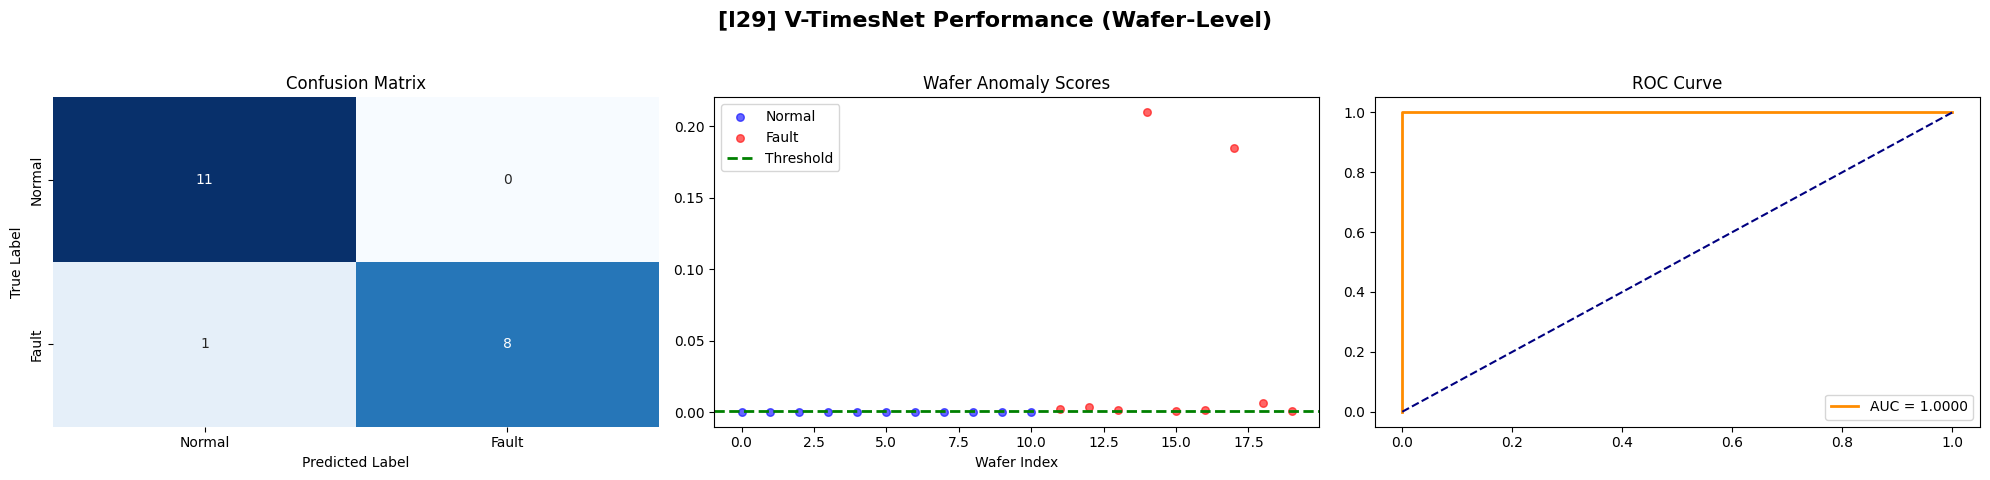


🧪 Experiment Target: l31
🔥 Start Training V-TimesNet (Device: cuda)
Epoch [10/30], Loss: 0.004012
Epoch [20/30], Loss: 0.019227
Epoch [30/30], Loss: 0.016220
✅ Training Complete.

📌 [V-TimesNet - l31] Evaluation Result
   - AUROC         : 0.9028
   - Best F1-Score : 0.8333
   - Best Threshold: 0.015633


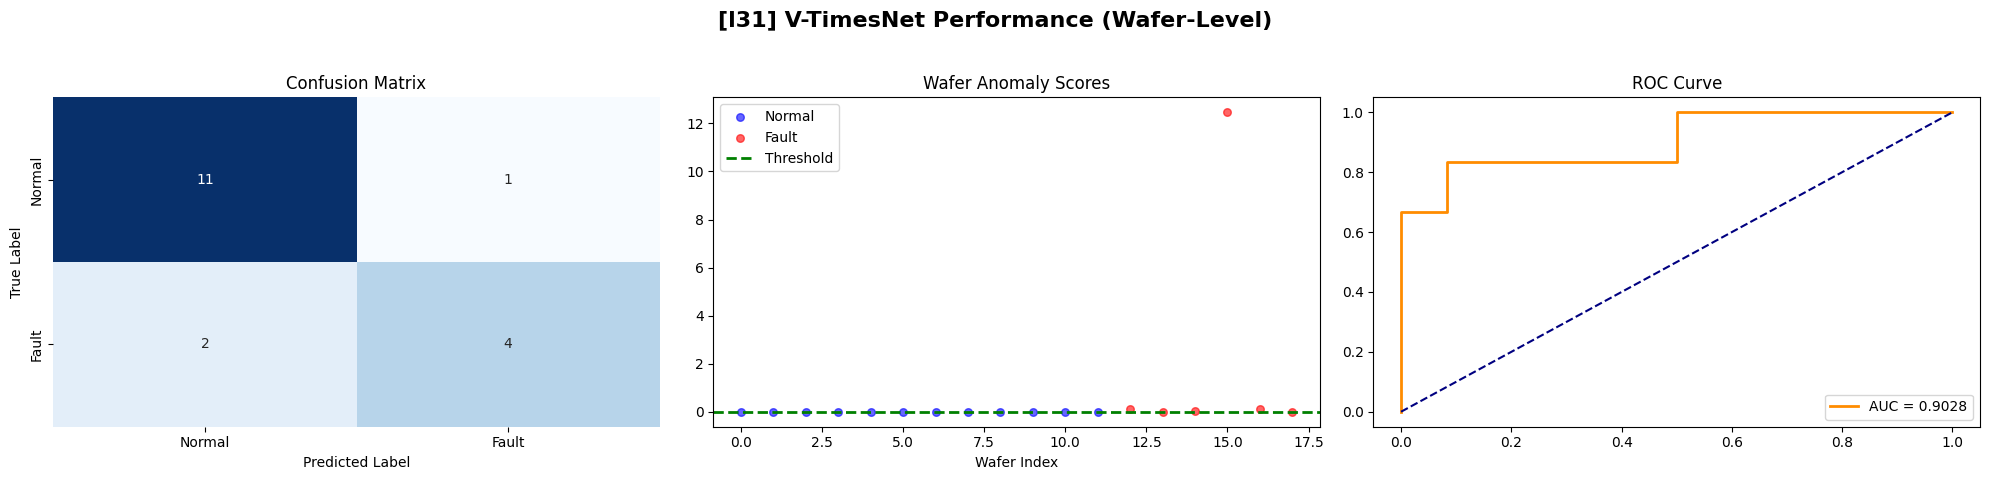


🧪 Experiment Target: l33
🔥 Start Training V-TimesNet (Device: cuda)
Epoch [10/30], Loss: 0.003908
Epoch [20/30], Loss: 0.002609
Epoch [30/30], Loss: 0.026056
✅ Training Complete.

📌 [V-TimesNet - l33] Evaluation Result
   - AUROC         : 0.9722
   - Best F1-Score : 0.9091
   - Best Threshold: 0.044802


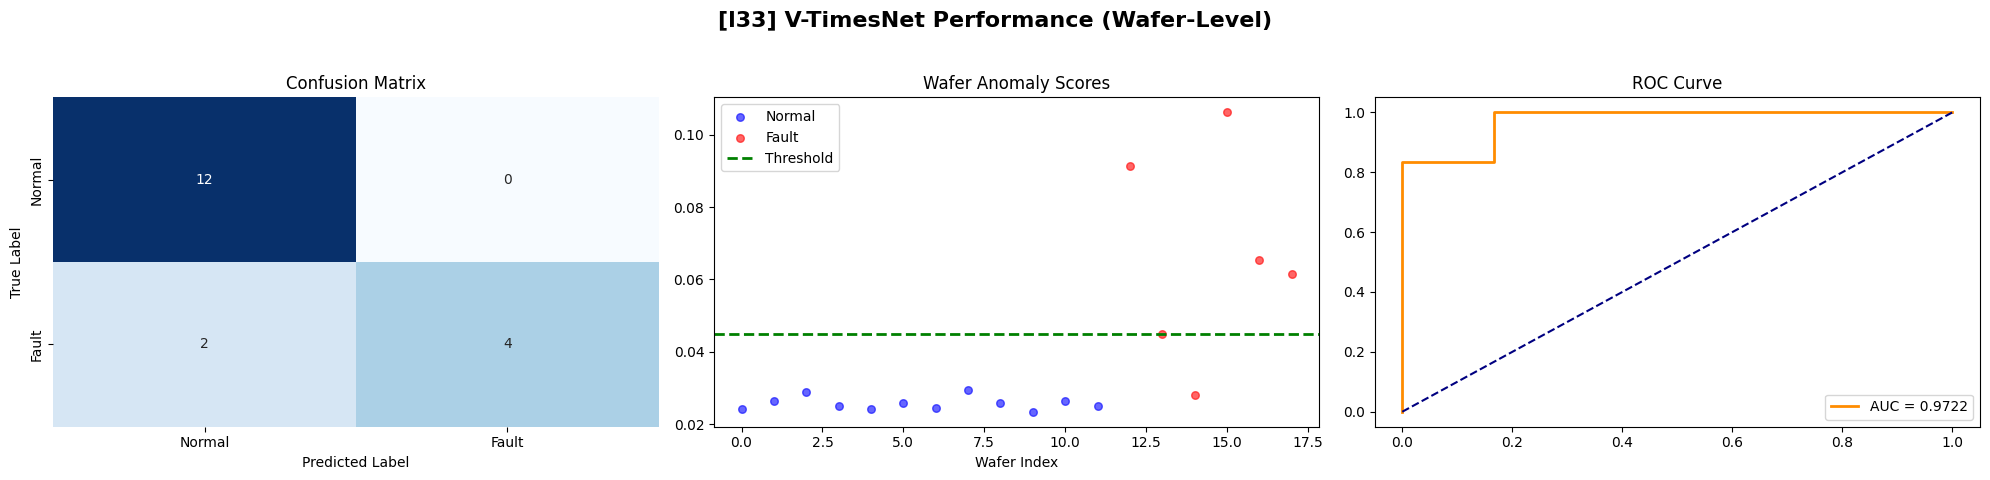


🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟
🏆 Overall Experiment Results Summary
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟
 - [l29] AUROC: 1.0000 | F1-Score: 1.0000
 - [l31] AUROC: 0.9028 | F1-Score: 0.8333
 - [l33] AUROC: 0.9722 | F1-Score: 0.9091


In [11]:
# ==========================================
# 5. V-TimesNet 학습 및 전체 실험 실행
# ==========================================
import numpy as np

# 하이퍼파라미터 설정
SEQ_LEN = 32
N_FEATURES = 19
D_MODEL = 64
EPOCHS = 30
LR = 0.001
TOP_K = 3 # 주파수 상위 3개 주기 사용

# 모든 실험 결과 저장을 위한 딕셔너리
all_results = {}

print(f"\n🚀 Starting Evaluation for All Experiments: {list(datasets.keys())}")

# datasets 딕셔너리에 있는 모든 실험(l29, l31, l33 등)에 대해 반복 실행
for EXP_ID in datasets.keys():
    print("\n" + "="*50)
    print(f"🧪 Experiment Target: {EXP_ID}")
    print("="*50)

    # 1. DataLoader 가져오기
    train_loader, (test_norm_tensor, ids_test_norm), (test_fault_tensor, ids_test_fault) = \
        get_data_loaders(EXP_ID, datasets)

    # 2. 모델 초기화 (매 실험마다 새로운 모델로 가중치 초기화)
    model = VTimesNet(
        seq_len=SEQ_LEN,
        n_features=N_FEATURES,
        d_model=D_MODEL,
        k=TOP_K
    )

    # 3. 모델 학습
    trained_model = train_vtimesnet(model, train_loader, epochs=EPOCHS, lr=LR)

    # 4. 추론 (Anomaly Score 계산)
    # 정상 테스트 데이터
    norm_scores = inference_vtimesnet(trained_model, test_norm_tensor)

    # 불량 테스트 데이터 (불량 데이터가 존재하는지 안전장치 추가)
    if len(test_fault_tensor) > 0:
        fault_scores = inference_vtimesnet(trained_model, test_fault_tensor)
    else:
        fault_scores = np.array([])
        ids_test_fault = np.array([])

    # 5. 웨이퍼 단위 집계 (Max Score Strategy)
    norm_wafer_ids, norm_wafer_scores = aggregate_wafer_scores(norm_scores, ids_test_norm, method='max')

    if len(fault_scores) > 0:
        fault_wafer_ids, fault_wafer_scores = aggregate_wafer_scores(fault_scores, ids_test_fault, method='max')
    else:
        fault_wafer_ids, fault_wafer_scores = np.array([]), np.array([])

    # 6. 결과 병합 및 시각화
    final_scores = np.concatenate([norm_wafer_scores, fault_wafer_scores])
    final_labels = np.concatenate([np.zeros(len(norm_wafer_scores)), np.ones(len(fault_wafer_scores))]) # 0: Normal, 1: Fault

    # 7. 성능 평가 (정상/불량 라벨이 모두 존재할 때만 평가 진행)
    if len(np.unique(final_labels)) > 1:
        auc_score, f1 = evaluate_performance("V-TimesNet", EXP_ID, final_scores, final_labels)
        all_results[EXP_ID] = {'AUROC': auc_score, 'F1-Score': f1}
    else:
        print(f"⚠️ [{EXP_ID}] Evaluation skipped: Missing either normal or fault test data.")

# ==========================================
# 6. 전체 실험 결과 요약 출력
# ==========================================
print("\n" + "🌟"*25)
print("🏆 Overall Experiment Results Summary")
print("🌟"*25)
for exp, res in all_results.items():
    print(f" - [{exp}] AUROC: {res['AUROC']:.4f} | F1-Score: {res['F1-Score']:.4f}")